In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
import math
import warnings
from os.path import join
import os
os.getcwd()

'/home/rstudio/207/207_final_project_Alvaro_Jake_Ruchi_Phillip'

In [2]:
# # Makes working dir the repo - may be needed if have path issues...
# %cd 207_final_project_Alvaro_Jake_Ruchi_Phillip

Data Source: The California Weather and Fire Prediction Dataset (1984–2025) with Engineered Features is available at https://zenodo.org/records/14712845.

In [5]:
# Parameters
input_path = join(os.getcwd(), 'data', 'CA_Weather_Fire_Dataset_1984-2025.csv')
# path to cleaned data to be used for analysis
output_path = join(os.getcwd(), 'data', 'analysis_df.csv')

In [6]:
# Load data
df = pd.read_csv(input_path)

In [7]:
# Cleaning
# Make season categorical
season = CategoricalDtype(
    categories=['Winter', 'Spring', 'Summer', 'Fall'],
    ordered=False
)

df['SEASON'] = df['SEASON'].astype(season)

In [8]:
# Add DAYS_WITHOUT_RAIN

# True on days with any rain; False on dry days
rain_today = df["PRECIPITATION"] > 0

# creates a running group number that increases by 1 every time a rainy day occurs
# this lets us split the timeline into segments separated by rain
group_id = rain_today.cumsum()

# for dry days (~rain_today), count how many consecutive dry days have occurred within each segment
# resets to 0 after each rain event (because group_id changes on rain days)
df["DAYS_WITHOUT_RAIN"] = (~rain_today).groupby(group_id).cumcount()

In [11]:
# Make column lists

# These cols will likely not inform EDA much. Use this list for easy access
# DATE/YEAR: not helpful in EDA, assuming the underlying climate conditions across years remain relatively constant
# DAY_OF_YEAR: likely same info as Season var
exclude_cols = ['DATE', 'YEAR', 'DAY_OF_YEAR', 'TEMP_RANGE', 'WIND_TEMP_RATIO']

feature_cols = [c for c in df.columns if c not in exclude_cols]
feature_cols.remove('FIRE_START_DAY')
target_col = 'FIRE_START_DAY'
numeric_cols = feature_cols.copy()
numeric_cols.remove('SEASON')
cols = feature_cols + [target_col]

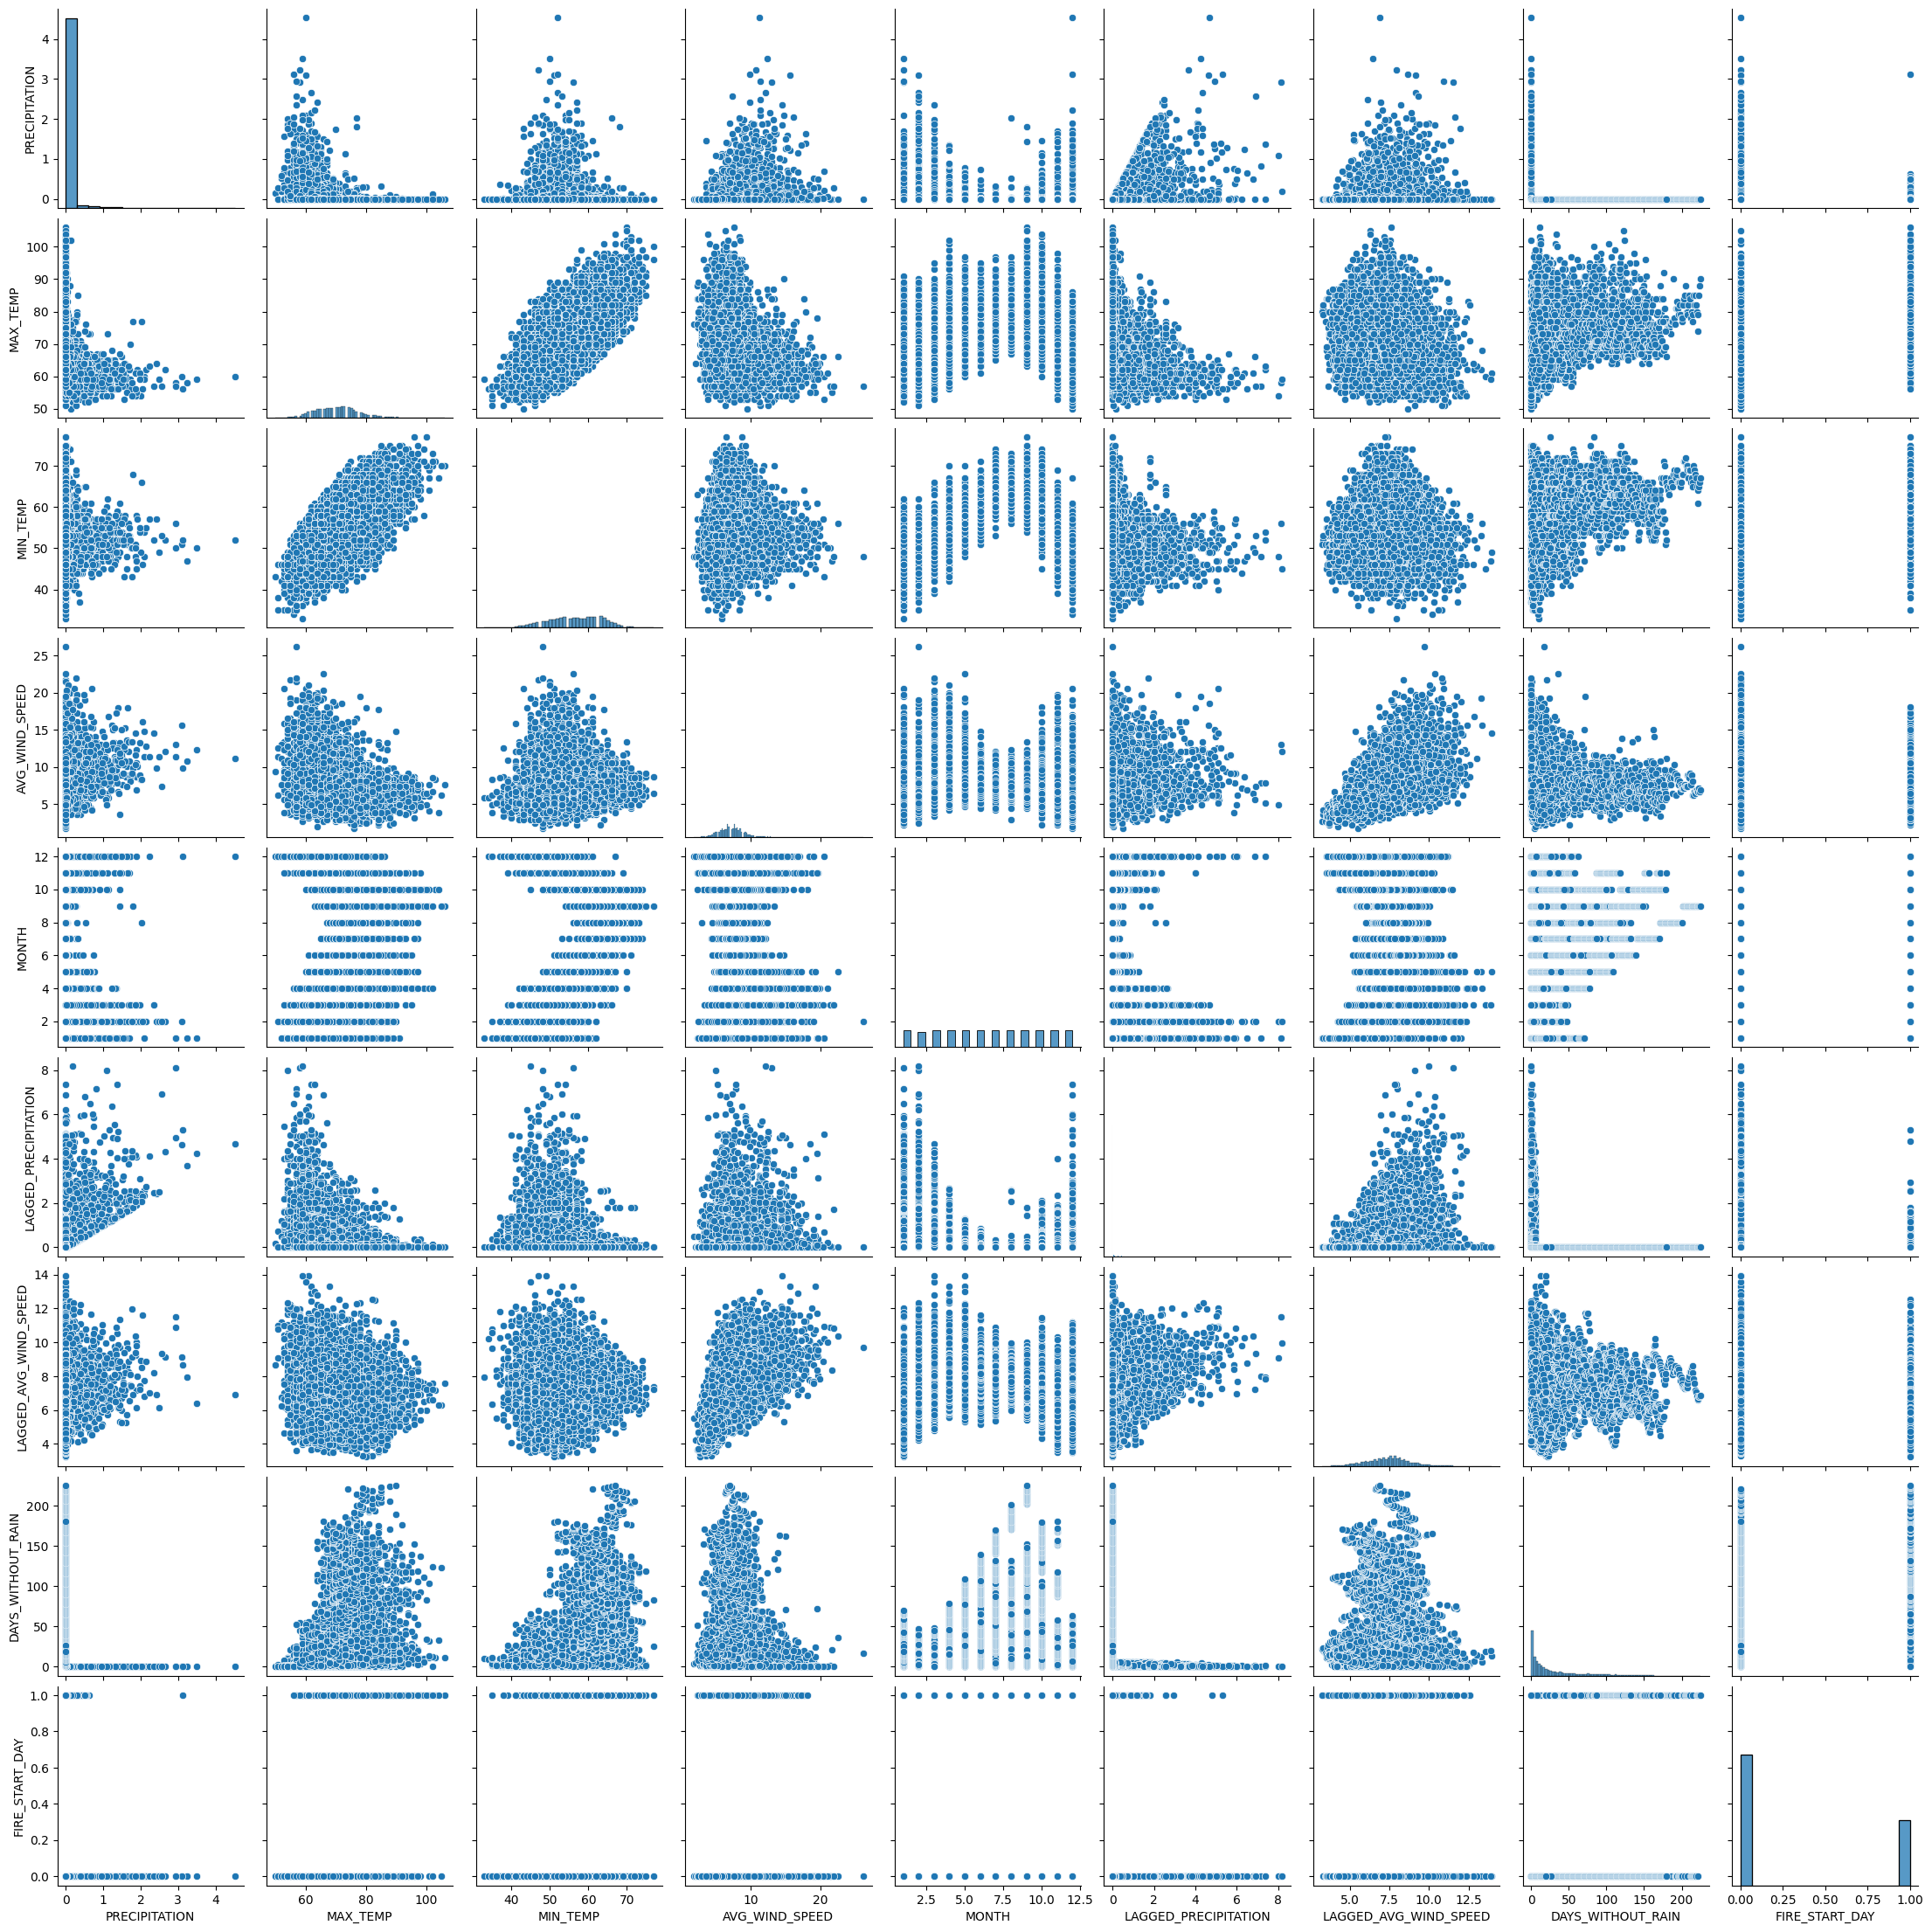

In [12]:
# Visualize
sns.pairplot(df[cols], kind='scatter')

In [13]:
# Investigate collinearities
# For numeric variables, 
#    - calculate Pearson corr for measure of linear correlation
#    - calculate Spearman/Kendall correlation for measure of similarly ranked values in both series
corr_pearson = df[numeric_cols].corr(method='pearson')
corr_spearman = df[numeric_cols].corr(method='spearman')
corr_kendall = df[numeric_cols].corr(method='kendall')

In [14]:
corr_pearson
#corr_spearman
#corr_kendall

,PRECIPITATION,MAX_TEMP,MIN_TEMP,AVG_WIND_SPEED,MONTH,LAGGED_PRECIPITATION,LAGGED_AVG_WIND_SPEED,DAYS_WITHOUT_RAIN
PRECIPITATION,1.000000,-0.237085,-0.112487,0.214149,-0.075310,0.473865,0.049551,-0.144809
MAX_TEMP,-0.237085,1.000000,0.636894,-0.165375,0.272141,-0.337799,-0.077685,0.383935
MIN_TEMP,-0.112487,0.636894,1.000000,0.126739,0.278546,-0.302689,0.101338,0.513130
AVG_WIND_SPEED,0.214149,-0.165375,0.126739,1.000000,-0.145147,0.112432,0.595673,-0.012403
MONTH,-0.075310,0.272141,0.278546,-0.145147,1.000000,-0.167245,-0.193652,0.261358
LAGGED_PRECIPITATION,0.473865,-0.337799,-0.302689,0.112432,-0.167245,1.000000,0.172813,-0.266376
LAGGED_AVG_WIND_SPEED,0.049551,-0.077685,0.101338,0.595673,-0.193652,0.172813,1.000000,0.002756
DAYS_WITHOUT_RAIN,-0.144809,0.383935,0.513130,-0.012403,0.261358,-0.266376,0.002756,1.000000


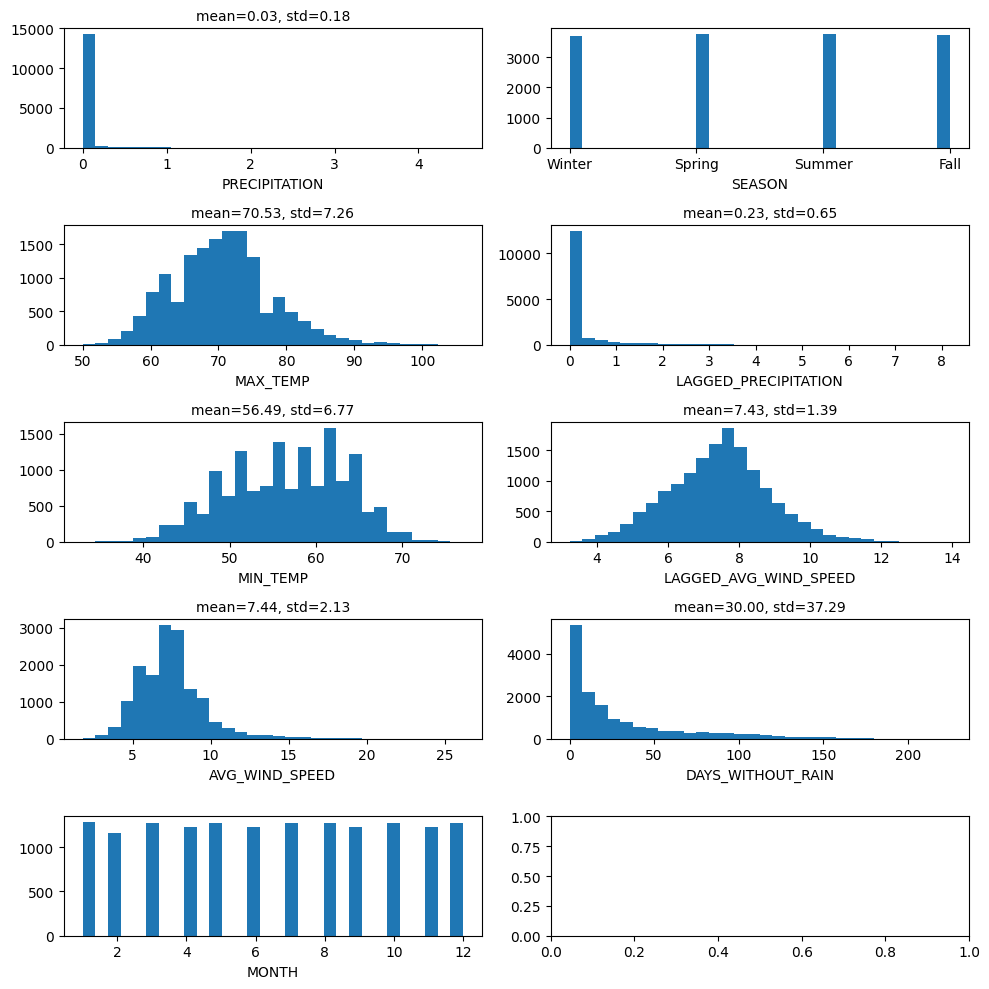

In [15]:
# Investigate distributions
rows = math.ceil(len(feature_cols)/2)
fig, axs = plt.subplots(rows, 2, figsize=(10,10))
for i, f in enumerate(feature_cols):
    row, col = i%rows, 0 if i<rows else 1
    axs[row, col].hist(df[f], bins=30)
    axs[row, col].set_xlabel(f'{f}')
    if f not in ['SEASON', 'MONTH']:
        mean, std = df[f].mean(), df[f].std()
        axs[row, col].set_title(f"mean={mean:.2f}, std={std:.2f}", fontsize=10)
plt.tight_layout()
plt.show()

In [16]:
# No distributions look too skewed such that they require some sort of transformation. 
# Recall: logistic regression doesnt require normality, but super skewed distros can cause performance issues
counts = df['PRECIPITATION'].sort_values(ascending=True).value_counts()

percentages_formatted = df['PRECIPITATION'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
# Concatenate counts and percentages into one DataFrame
result_df = pd.DataFrame({'Count': counts, 'Percentage': percentages_formatted})
print(result_df)

               Count Percentage
PRECIPITATION                  
0.00           13606      90.8%
0.01             146       1.0%
0.02              97       0.6%
0.03              68       0.5%
0.04              56       0.4%
...              ...        ...
3.10               1       0.0%
3.12               1       0.0%
3.23               1       0.0%
3.50               1       0.0%
4.53               1       0.0%

[184 rows x 2 columns]


In [17]:
# Missing values
df.isna().sum()

DATE                      0
PRECIPITATION             1
MAX_TEMP                  1
MIN_TEMP                  1
AVG_WIND_SPEED           12
FIRE_START_DAY            0
YEAR                      0
TEMP_RANGE                1
WIND_TEMP_RATIO          12
MONTH                     0
SEASON                    0
LAGGED_PRECIPITATION      0
LAGGED_AVG_WIND_SPEED     0
DAY_OF_YEAR               0
DAYS_WITHOUT_RAIN         0
dtype: int64

In [18]:
# Drop observations with NaN values
df2 = df.dropna(subset=['PRECIPITATION', 'AVG_WIND_SPEED', 'MIN_TEMP', 'MAX_TEMP'])
df2.isna().sum()

DATE                     0
PRECIPITATION            0
MAX_TEMP                 0
MIN_TEMP                 0
AVG_WIND_SPEED           0
FIRE_START_DAY           0
YEAR                     0
TEMP_RANGE               0
WIND_TEMP_RATIO          0
MONTH                    0
SEASON                   0
LAGGED_PRECIPITATION     0
LAGGED_AVG_WIND_SPEED    0
DAY_OF_YEAR              0
DAYS_WITHOUT_RAIN        0
dtype: int64

**Rationale for dropping rows**: Since the number of missing values is negligible compared to the size of our dataset, and we are treating each row as an independent observation, we can safely remove the rows containing missing values without affecting our analysis.

In [19]:
warnings.filterwarnings('ignore')
# Outlier Identification + Treatment
# Options for treatment: 
#   - winsorization (set lower/upper outliers to 1%/99% -iles)
#   - remove if small percentage of the data, do nothing if not?

for f in numeric_cols:
    print(f)
    # Identify outliers using 1.5*IQR
    q1_pctile, q3_pctile = df2[f].quantile(0.25), df2[f].quantile(0.75)
    iqr = q3_pctile - q1_pctile
    lower, upper = q1_pctile - (1.5*iqr), q3_pctile + (1.5*iqr)
    low_outliers, high_outliers = df2.loc[(df2[f] < lower), :], df2.loc[(df2[f] > upper), :]
    pct_outliers = (len(low_outliers) + len(high_outliers))/len(df2)
    print(f"pct of points outliers: {pct_outliers:.2%}")
    # Winsorize outliers
    original = df2[f].copy()
    df2[f] = df2[f].clip(lower=df2[f].quantile(0.01),
                         upper=df2[f].quantile(0.99))
    changed = (original != df2[f]).sum()
    pct_changed = changed / len(df2)
    print(f"pct data changed by winsorization: {changed}/{len(df2)} = {pct_changed:.2%}")
    print("=============")

PRECIPITATION
pct of points outliers: 9.22%
pct data changed by winsorization: 149/14976 = 0.99%
MAX_TEMP
pct of points outliers: 1.08%
pct data changed by winsorization: 237/14976 = 1.58%
MIN_TEMP
pct of points outliers: 0.01%
pct data changed by winsorization: 266/14976 = 1.78%
AVG_WIND_SPEED
pct of points outliers: 3.20%
pct data changed by winsorization: 262/14976 = 1.75%
MONTH
pct of points outliers: 0.00%
pct data changed by winsorization: 0/14976 = 0.00%
LAGGED_PRECIPITATION
pct of points outliers: 20.47%
pct data changed by winsorization: 148/14976 = 0.99%
LAGGED_AVG_WIND_SPEED
pct of points outliers: 1.23%
pct data changed by winsorization: 299/14976 = 2.00%
DAYS_WITHOUT_RAIN
pct of points outliers: 7.39%
pct data changed by winsorization: 144/14976 = 0.96%


In [20]:
# One-hot encode season and month
cat_features = ['SEASON', 'MONTH']
for c in cat_features:
    dummy_df = pd.get_dummies(df[c], drop_first=False, prefix=c)
    df = pd.concat([df, dummy_df], axis=1)
    df = df.drop(columns=[c])

In [21]:
df = df.drop(columns=exclude_cols)
df.columns

Index(['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED',
       'FIRE_START_DAY', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED',
       'DAYS_WITHOUT_RAIN', 'SEASON_Winter', 'SEASON_Spring', 'SEASON_Summer',
       'SEASON_Fall', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5',
       'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11',
       'MONTH_12'],
      dtype='object')

In [22]:
df2.to_csv(output_path, index=False)

In [ ]:
# If time
#- Consider doing Welch t-test (if normal) or Wilcoxon Rank sum (if not normal/skewed) to 
#see diff in means for Fire Start Day group vs. other group. How would this help us?

# Examine difference in means btwn fire start day and not fire start day
# Use Welch's t-test to calculate stat sig diff in means
# Assumes normality but with greater than 30 observations, CLT guarantees that. Also assumes no skewness
# Non-parametric test for diff is Wilcoxon Rank Sum Test



**Notes/Questions**
- How do we handle time dependency?

Logistic regression/gradient descent allows for dependence between observations. Will need to consider for train test split (ie use the more recent observations as the test set)

- What to do with time-related features for logistic regression?

Some seem relevant - ie season. But don't think about autocorrelations in observations re: the outcome variable. Think about every sample as independent and then for the time-related features, include them if you thinkn they inform risk for the observation on that given day

- What to do about collinearities? Do we need to handle?

Even if have a perfectly collinear feature, thats still mechanically fine for gradient descent. Gradient descent can handle anything mechanically.

But for the best performance, get rid of collinear features or combine them (add or multiply)

For fitting a logistic regression model, one COULD try every combo of features, fit model, and see which has the best AIC/BIC, but that may be beyond scope. 